In [4]:
from fastai.vision.all import *
from pathlib import Path
import torch, numpy as np, pandas as pd

# Traffic Sign Recognition

We'll build a traffic sign recognizer/classifier for Belgian traffic signs.  The dataset we'll use is downloaded from [people.ee.ethz.ch](https://people.ee.ethz.ch/~timofter/traffic_signs/). See publication:

@inproceedings{Timofte-BMVC-2011,
author = {Radu Timofte and Luc Van Gool},
title  = {Sparse representation based projections},
booktitle = {British Machine Vision Conference},
year   = {2011},
}

@article{Timofte-MVA-2011,
  author = {Radu Timofte and Karel Zimmermann and Luc {Van Gool}},
  title = {Multi-view Traffic Sign Detection, Recognition, and 3D Localisation},
  journal = {Machine Vision and Applications},
  year = {2011}, 
  doi  = {10.1007/s00138-011-0391-3},
}


In [5]:
# Fetch data from people.ee.ethz.ch
from zipfile import ZipFile
data_path = Path('./traffic-sign')
training_path = untar_data(url='https://people.ee.ethz.ch/~timofter/BelgiumTSC/BelgiumTSC_Training.zip', base=data_path.absolute(), data=data_path.absolute())
testing_path = untar_data(url='http://www.vision.ee.ethz.ch/~timofter/BelgiumTSC/BelgiumTSC_Testing.zip', base=data_path.absolute(), data=data_path.absolute())

## Data Discovery

Let's have a look at one single image from the dataset first, so we know what we're dealing with.

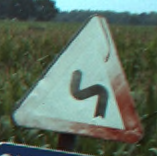

In [6]:
data_path = Path('./traffic-sign')
training_path = Path(data_path/'BelgiumTSC_Training')
testing_path = Path(data_path/'BelgiumTSC_Testing')
img = PILImage.create(training_path/'00006/00147_00000.ppm')
img.to_thumb(400)

In [7]:
training_path.absolute()

Path('/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Training')

## Build a quick first model

We'll use FastAI to build a quick first model and see how far we get with that:

In [6]:
fnames = get_image_files(training_path) # gives us something like: [Path('/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Training/00006/00221_00000.ppm'),Path('/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Training/00006/00327_00001.ppm'),Path('/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Training/00006/00326_00001.ppm')]
def label_func(x): return x.parent.name
dls = ImageDataLoaders.from_path_func(training_path.absolute(), fnames, label_func, valid_ptc=0.2, seed=42, item_tfms=Resize(224))
dls.valid_ds.items[:3]

[Path('traffic-sign/BelgiumTSC_Training/00041/01401_00002.ppm'),
 Path('traffic-sign/BelgiumTSC_Training/00041/01149_00000.ppm'),
 Path('traffic-sign/BelgiumTSC_Training/00056/00151_00000.ppm')]

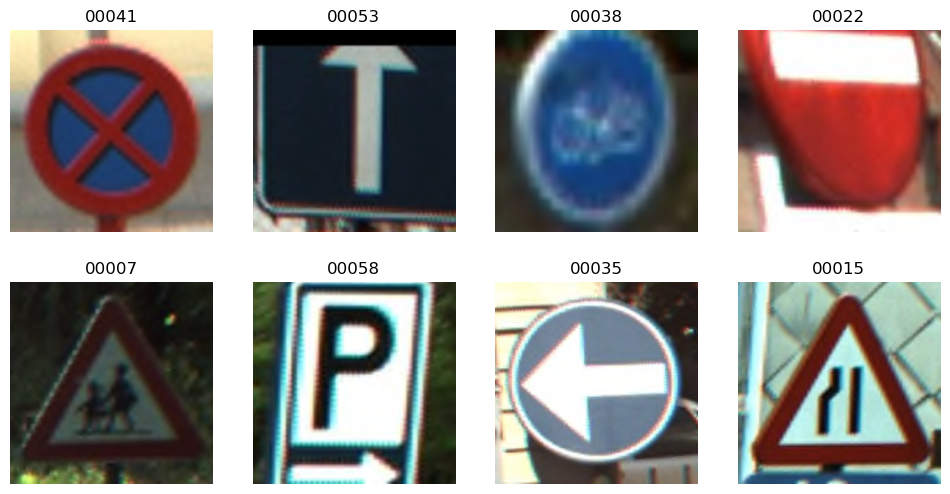

In [7]:
dls.show_batch(nrows=2, ncols=4)

In [8]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(2)

/home/xstof/mambaforge/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/xstof/mambaforge/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,2.765614,0.682876,0.177243,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.525985,0.168609,0.049234,00:17
1,0.250160,0.116856,0.032823,00:17


Let's experiment with using a different learning rate; inspired by the learning rate finder:

In [10]:
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

KeyboardInterrupt: 

In [9]:
#learn = vision_learner(dls, resnet50, metrics=error_rate)
learn = vision_learner(dls, resnet34, metrics=error_rate)
#learn.fine_tune(9, base_lr=1e-4, freeze_epochs=3)
learn.fine_tune(60, base_lr=1e-4)

epoch,train_loss,valid_loss,error_rate,time
0,5.272032,3.511821,0.810722,00:12


epoch,train_loss,valid_loss,error_rate,time
0,4.322254,3.168630,0.722101,00:16
1,4.073076,2.831528,0.649891,00:16
2,3.727599,2.497461,0.554705,00:16
3,3.388522,2.206383,0.492341,00:17
4,3.040637,1.924404,0.439825,00:17
5,2.693980,1.672572,0.386214,00:17
6,2.407907,1.453600,0.324945,00:17
7,2.051530,1.267668,0.291028,00:17
8,1.805684,1.090083,0.249453,00:17
9,1.539369,0.948155,0.214442,00:17


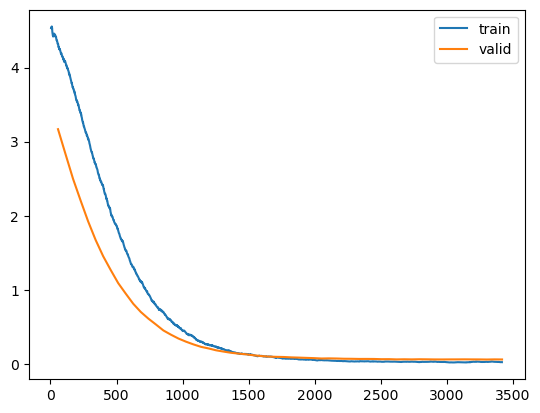

In [10]:
learn.recorder.plot_loss()

What we learn here is that with a slow learning rate and 60 epochs, we're getting down to an error rate of 0.0185 or approximately 2%.  Let's have a look at where those errors are in our data set by looking at a couple of examples.

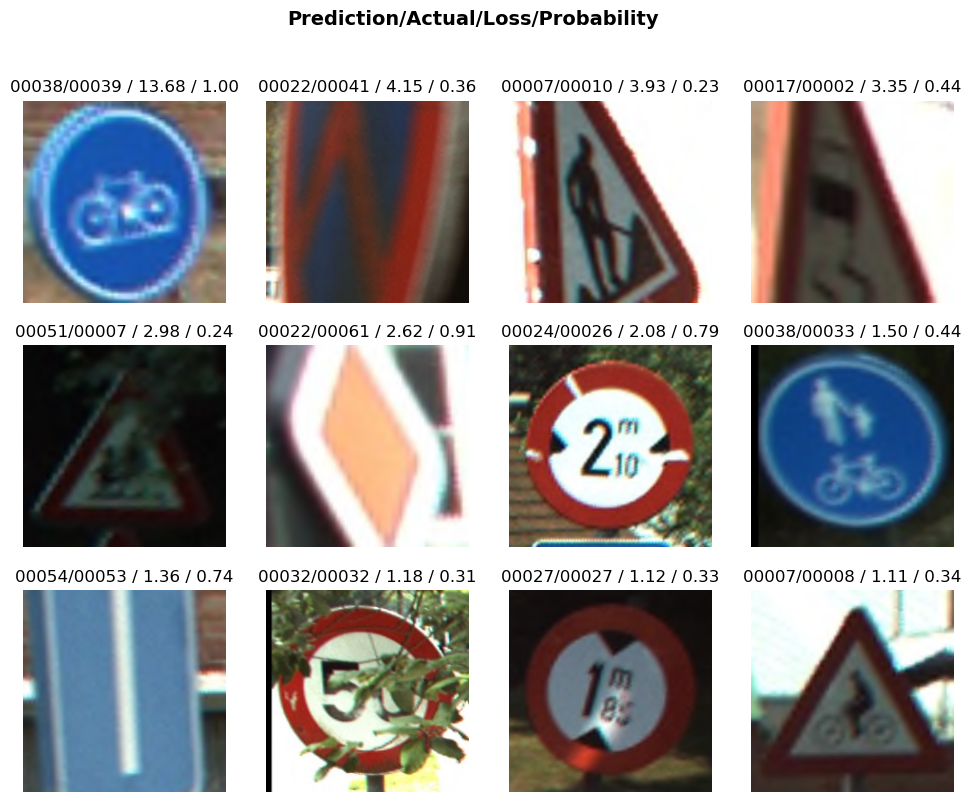

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
# interp.plot_confusion_matrix(figsize=(12,12), dpi=60)
# interp.most_confused()
interp.plot_top_losses(12)

In [12]:
learn.lr

0.001

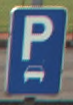

In [13]:
img = PILImage.create(training_path/'00047/00010_00000.ppm')
img.to_thumb(400)

## Data Augmentation

We'll bring more variation in our dataset by augmenting our data now: resizing, skewing etc..

In [26]:
fnames = get_image_files(training_path) # gives us something like: [Path('/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Training/00006/00221_00000.ppm'),Path('/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Training/00006/00327_00001.ppm'),Path('/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Training/00006/00326_00001.ppm')]
def label_func(x): return x.parent.name
print(f'taking training images from path: {training_path.absolute()}')
# dls = ImageDataLoaders.from_path_func(training_path.absolute(), fnames, label_func, valid_ptc=0.2, seed=42, 
#                                     item_tfms=RandomResizedCropGPU(224, min_scale=.5),
#                                     batch_tfms=aug_transforms())
dls = ImageDataLoaders.from_path_func(training_path.absolute(), fnames, label_func, valid_ptc=0.2, seed=42, 
                                      item_tfms=Resize(224),
                                      batch_tfms=aug_transforms())

taking training images from path: /home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Training


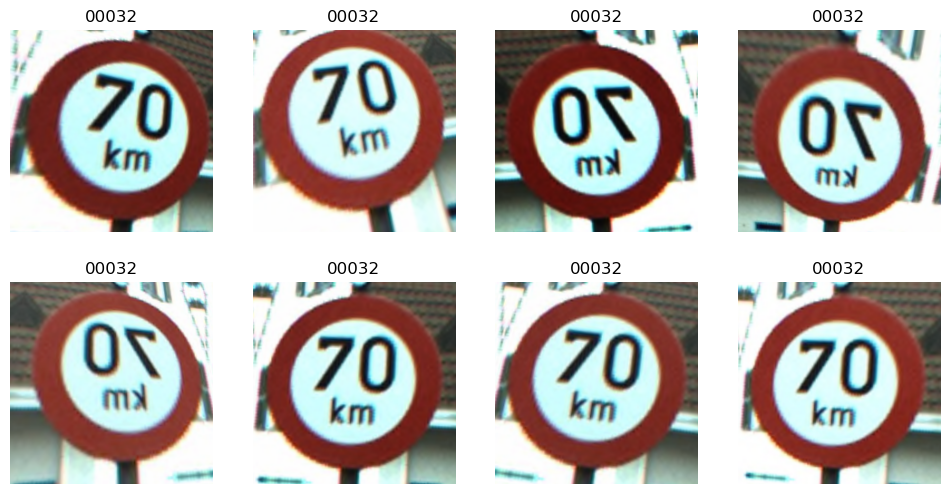

In [27]:
dls.train.show_batch(max_n=8, nrows=2, unique=True)

Now let's train another model using these augmented versions of our images:

In [28]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

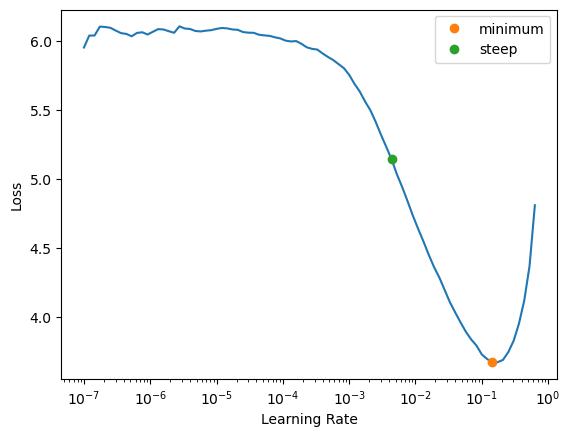

In [29]:
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [30]:
learn.fine_tune(30, base_lr=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,3.608980,1.084114,0.268053,00:13


epoch,train_loss,valid_loss,error_rate,time
0,1.430907,0.698026,0.169584,00:17
1,1.056159,0.454872,0.114880,00:17
2,0.749442,0.302111,0.082057,00:17
3,0.528836,0.194878,0.048140,00:17
4,0.355295,0.115626,0.030635,00:17
5,0.253510,0.082918,0.021882,00:17
6,0.168605,0.061095,0.014223,00:17
7,0.124957,0.046257,0.010941,00:17
8,0.096753,0.034474,0.008753,00:17
9,0.074080,0.032612,0.006565,00:18


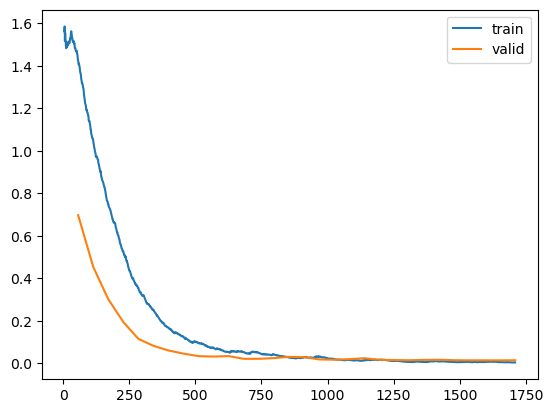

In [31]:
learn.recorder.plot_loss()

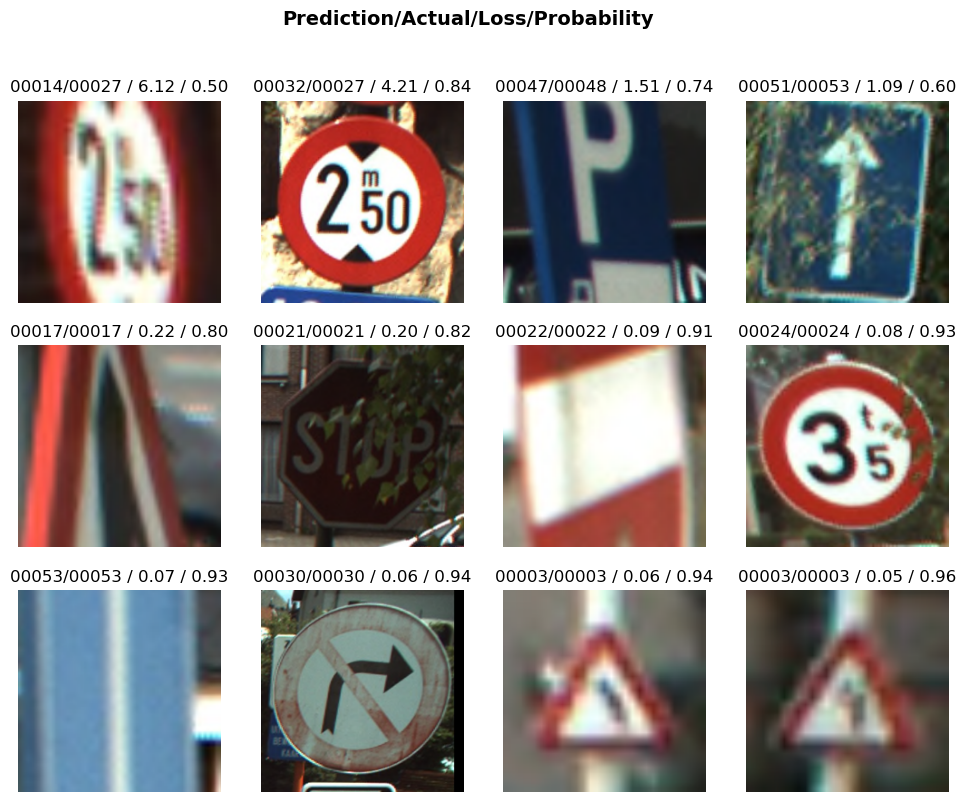

In [32]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(12)

## Data Cleaning

Something tells us that there might still be images wrongly classified in our training data.  We can explore this using the `ImageClassifierCleaner` widget.  When we do so, it turns out that indeed there's images that are wrongly classified in our dataset.  Let's clean those up.

In [22]:
import ipywidgets
from fastai.vision.widgets import ImageClassifierCleaner
cleaner = ImageClassifierCleaner(learn)
cleaner

In [23]:
deleted = cleaner.delete()
for d in deleted: print(f'deleted: {d}')
for idx,cat in cleaner.change(): print(f'index: {idx} in cat: {cat}')

deleted: 3
index: 2 in cat: 00038
index: 6 in cat: 00038


In [24]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()

In [25]:
#for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)
for idx,cat in cleaner.change(): print(f'move {cleaner.fns[idx]} to {Path(cleaner.fns[idx]).parent.parent / cat}')
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), Path(cleaner.fns[idx]).parent.parent / cat)

move traffic-sign/BelgiumTSC_Training/00039/01911_00001.ppm to traffic-sign/BelgiumTSC_Training/00038
move traffic-sign/BelgiumTSC_Training/00039/01911_00002.ppm to traffic-sign/BelgiumTSC_Training/00038


After our cleaning operation, our error rate went down even a bit further, to less than 0,5%.

## Testing the Model

We now have a model that we can test against a testing data set.  Let's download that first:

In [33]:
test_files = get_image_files(testing_path)
test_files_string = test_files.map(lambda f: str(f.absolute()))
print(f'file {test_files[0]} has correct label: {label_func(test_files[0])}')
type(test_files_string)

file traffic-sign/BelgiumTSC_Testing/00006/02039_00002.ppm has correct label: 00006


fastcore.foundation.L

In [34]:
testdata = pd.DataFrame(np.array(test_files_string) , columns = ['filename'])
testdata

,filename
0,/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Testing/00006/02039_00002.ppm
1,/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Testing/00006/02039_00001.ppm
2,/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Testing/00006/02039_00000.ppm
3,/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Testing/00006/02083_00000.ppm
4,/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Testing/00006/02083_00002.ppm
...,...
2515,/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Testing/00018/02030_00000.ppm
2516,/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Testing/00018/01984_00001.ppm
2517,/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Testing/00018/02193_00002.ppm
2518,/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Testing/00018/02194_00000.ppm


Let's extend our testdata with a column that contains the ground truth:

In [35]:
testdata['label'] = testdata.apply(lambda row: label_func(Path(row['filename'])), axis = 1)
testdata

,filename,label
0,/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Testing/00006/02039_00002.ppm,00006
1,/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Testing/00006/02039_00001.ppm,00006
2,/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Testing/00006/02039_00000.ppm,00006
3,/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Testing/00006/02083_00000.ppm,00006
4,/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Testing/00006/02083_00002.ppm,00006
...,...,...
2515,/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Testing/00018/02030_00000.ppm,00018
2516,/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Testing/00018/01984_00001.ppm,00018
2517,/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Testing/00018/02193_00002.ppm,00018
2518,/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Testing/00018/02194_00000.ppm,00018


Now we need the predictions from our model for each row, so we can compare those against the truth label.  For a single item this goes like this:

In [84]:
predicted_label, predicted_idx, predicted_probs = learn.predict(testdata['filename'][0])
predicted_label2, predicted_idx, predicted_probs = learn.predict(testdata['filename'][2515])
predicted_label3, predicted_idx, predicted_probs = learn.predict(testdata['filename'][1000])
print(f'for file {testdata.filename[0]} we predicted a label of {predicted_label}')
print(f'for file {testdata.filename[2515]} we predicted a label of {predicted_label2}')
print(f'for file {testdata.filename[1000]} we predicted a label of {predicted_label3}')

for file /home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Testing/00006/02039_00002.ppm we predicted a label of 00005
for file /home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Testing/00018/02030_00000.ppm we predicted a label of 00018
for file /home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Testing/00019/02124_00000.ppm we predicted a label of 00019


For all our labels:

In [85]:
def predict(filename): 
    predicted_label, _, _ = learn.predict(filename)
    return predicted_label
# predict(testdata['filename'][0])

In [86]:
# testdata['predicted'] = testdata.apply(lambda row: predict(row['filename']), axis=1)
# testdata

In [87]:
# get a dataloaders that has the exact same transformations applied as during training:
tst_dl = learn.dls.test_dl(testdata.filename)
preds, _ = learn.get_preds(dl=tst_dl)
preds

TensorBase([[1.1896e-03, 3.2670e-05, 9.1291e-06,  ..., 2.1299e-06,
             1.9771e-07, 6.4971e-07],
            [7.4278e-05, 2.8059e-06, 5.6598e-06,  ..., 7.9164e-07,
             8.2710e-07, 4.7385e-07],
            [1.3759e-04, 1.2551e-04, 1.1870e-04,  ..., 1.3204e-05,
             1.2395e-05, 3.2555e-05],
            ...,
            [2.2055e-07, 1.0322e-06, 1.1944e-05,  ..., 1.5188e-07,
             1.5343e-06, 6.6106e-07],
            [1.4748e-07, 2.0833e-07, 1.8539e-07,  ..., 2.2542e-08,
             9.2468e-07, 1.0912e-07],
            [7.6813e-08, 4.3783e-09, 1.5067e-08,  ..., 2.6169e-09,
             1.4087e-08, 2.1832e-09]])

In [88]:
preds[0]

TensorBase([1.1896e-03, 3.2670e-05, 9.1291e-06, 3.8356e-05, 2.5520e-04,
            9.5691e-01, 4.1199e-02, 2.4053e-06, 2.2224e-05, 6.6508e-06,
            2.9380e-06, 9.0039e-07, 5.7958e-07, 2.8193e-07, 1.2864e-06,
            8.2779e-08, 5.7793e-06, 7.6418e-07, 4.1857e-06, 6.6967e-08,
            6.4850e-07, 5.7714e-06, 3.5365e-08, 1.5344e-06, 1.2382e-04,
            1.7104e-06, 3.4046e-06, 6.3849e-06, 4.5234e-07, 4.1998e-05,
            1.7630e-07, 2.4071e-07, 2.4519e-07, 9.8147e-07, 1.1657e-06,
            2.7170e-07, 9.9690e-07, 3.8178e-07, 6.5608e-08, 1.0690e-07,
            9.0703e-08, 3.6442e-06, 2.3846e-07, 7.8937e-08, 6.5177e-07,
            2.4670e-07, 1.4663e-05, 6.6853e-06, 1.0686e-06, 1.9420e-06,
            3.4722e-06, 2.9240e-08, 5.8613e-06, 5.9746e-09, 2.1060e-07,
            1.2808e-06, 1.7598e-06, 4.8697e-06, 7.5268e-05, 2.1299e-06,
            1.9771e-07, 6.4971e-07])

In [89]:
preds[0].sum()

TensorBase(1.)

In [90]:
print(f'index of max value in first row is: {preds[0].argmax()}') # this gives us the index of where the max value in this row is:
preds_indexes = preds.argmax(dim=1)
preds_indexes

index of max value in first row is: 5


TensorBase([ 5,  6,  6,  ..., 18, 18, 18])

Now we have the indexes for the max values for each row in our predictions.  Let's translate that to the actual label:

In [91]:
preds_indexes_list = L(preds_indexes.tolist())
pred_labels = preds_indexes_list.map(lambda idx: learn.dls.vocab[idx])
pred_labels[:5]

(#5) ['00005','00006','00006','00005','00006']

Lets turn this information into another column on our dataframe:

In [98]:
testdata['predicted'] = pd.DataFrame(np.array(pred_labels))
testdata['correct'] = testdata.label == testdata.predicted
testdata

,filename,label,predicted,correct
0,/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Testing/00006/02039_00002.ppm,00006,00005,False
1,/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Testing/00006/02039_00001.ppm,00006,00006,True
2,/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Testing/00006/02039_00000.ppm,00006,00006,True
3,/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Testing/00006/02083_00000.ppm,00006,00005,False
4,/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Testing/00006/02083_00002.ppm,00006,00006,True
...,...,...,...,...
2515,/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Testing/00018/02030_00000.ppm,00018,00018,True
2516,/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Testing/00018/01984_00001.ppm,00018,00018,True
2517,/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Testing/00018/02193_00002.ppm,00018,00018,True
2518,/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Testing/00018/02194_00000.ppm,00018,00018,True


In [103]:
correctCount = testdata.correct.sum()
totalCount = testdata.correct.count()
print(f'Out of {totalCount} items {correctCount} were predicted correctly.  This is {(correctCount/totalCount)*100}%')

Out of 2520 items 2467 were predicted correctly.  This is 97.89682539682539%


## Trying convnext_large_in22ft1k

Our choice for `resnet` might not be optimal.  Let's have a look if an architecture like `convnext` (which should perform better and be better suitable for transfer learning) significantly impacts the results:

In [7]:
!pip install timm

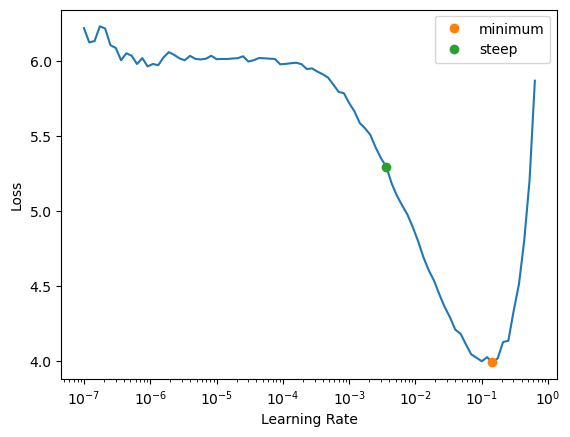

In [13]:
import timm
fnames = get_image_files(training_path) # gives us something like: [Path('/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Training/00006/00221_00000.ppm'),Path('/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Training/00006/00327_00001.ppm'),Path('/home/xstof/code/xstofai/nbs/traffic-sign/BelgiumTSC_Training/00006/00326_00001.ppm')]
def label_func(x): return x.parent.name
dls = ImageDataLoaders.from_path_func(training_path.absolute(), fnames, label_func, valid_ptc=0.2, seed=42, 
                                      bs = 32,
                                      item_tfms=Resize(224),
                                      batch_tfms=aug_transforms())

# arch = "convnext_large_in22ft1k"
# arch = "convnext_base_in22ft1k"
# arch = "convnext_small_in22k"
arch = "convnext_tiny"
learn = vision_learner(dls, arch, metrics=error_rate)
lr_min,lr_steep = learn.lr_find(suggest_funcs=(minimum, steep))

In [ ]:
torch.cuda.empty_cache() 
learn.fine_tune(40, base_lr=5*0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.954276,1.035131,0.152079,01:08


epoch,train_loss,valid_loss,error_rate,time
0,0.461623,0.096517,0.024070,02:58
1,0.176597,0.045619,0.013129,03:05
2,0.174104,0.078769,0.028446,03:04
3,0.223794,0.124076,0.029540,03:08
4,0.179282,0.093229,0.013129,03:05


In [12]:
torch.cuda.empty_cache()

In [10]:
learn.dls.bs

64